In [1]:
from qiskit_dynamics import DynamicsBackend, Solver
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import (
    BackendEstimator,
    Estimator,
    StatevectorEstimator,
    BackendEstimatorV2,
)
from qiskit_aer.primitives import (
    Estimator as AerEstimator,
    EstimatorV2 as AerEstimatorV2,
)
from qiskit_aer import AerSimulator
from rl_qoc.custom_jax_sim import (
    PulseEstimatorV2,
)
import numpy as np
from qiskit.compiler import schedule as build_schedule
import jax

jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")

In [2]:
from qiskit.transpiler import InstructionProperties

from qiskit import pulse
from typing import Optional, List, Dict
from qiskit.circuit import Gate
from qiskit.circuit.library import get_standard_gate_name_mapping
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management import (
    FixedFrequencyTransmon,
    EchoedCrossResonance,
)
from qiskit_experiments.library import RoughDragCal, RoughXSXAmplitudeCal
from itertools import permutations


def perform_standard_calibrations(
    backend: DynamicsBackend, calibration_files: Optional[List[str]] = None
):
    """
    Generate baseline single qubit gates (X, SX, RZ, H) for all qubits using traditional calibration experiments
    :param backend: Dynamics Backend on which calibrations should be run
    :param calibration_files: Optional calibration files containing single qubit gate calibrations for provided
        DynamicsBackend instance (Qiskit Experiments does not support this feature yet)

    """

    target, qubits = backend.target, range(backend.num_qubits)
    num_qubits = len(qubits)
    single_qubit_properties = {(qubit,): None for qubit in qubits}
    single_qubit_errors = {(qubit,): 0.0 for qubit in qubits}

    control_channel_map = backend.options.control_channel_map
    physical_control_channel_map = None
    if control_channel_map is not None:
        physical_control_channel_map = {
            (qubit_pair[0], qubit_pair[1]): backend.control_channel((qubit_pair[0], qubit_pair[1]))
            for qubit_pair in control_channel_map
        }
    elif num_qubits > 1:
        all_to_all_connectivity = tuple(permutations(qubits, 2))
        control_channel_map = {
            (q[0], q[1]): index for index, q in enumerate(all_to_all_connectivity)
        }
        physical_control_channel_map = {
            (q[0], q[1]): [pulse.ControlChannel(index)]
            for index, q in enumerate(all_to_all_connectivity)
        }
    backend.set_options(control_channel_map=control_channel_map)
    coupling_map = [list(qubit_pair) for qubit_pair in control_channel_map]
    two_qubit_properties = {qubits: None for qubits in control_channel_map}
    two_qubit_errors = {qubits: 0.0 for qubits in control_channel_map}
    standard_gates: Dict[str, Gate] = get_standard_gate_name_mapping()  # standard gate library
    fixed_phase_gates, fixed_phases = ["z", "s", "sdg", "t", "tdg"], np.pi * np.array(
        [1, 0.5, -0.5, 0.25, -0.25]
    )
    other_gates = ["rz", "id", "h", "x", "sx", "reset", "delay"]
    single_qubit_gates = fixed_phase_gates + other_gates
    two_qubit_gates = ["ecr"]
    exp_results = {}
    existing_cals = calibration_files is not None

    phi: Parameter = standard_gates["rz"].params[0]
    if existing_cals:
        cals = Calibrations.load(files=calibration_files)
    else:
        cals = Calibrations(
            coupling_map=coupling_map,
            control_channel_map=physical_control_channel_map,
            libraries=[
                FixedFrequencyTransmon(basis_gates=["x", "sx"]),
                EchoedCrossResonance(basis_gates=["cr45p", "cr45m", "ecr"]),
            ],
            backend_name=backend.name,
            backend_version=backend.backend_version,
        )
    if (
        len(target.instruction_schedule_map().instructions) <= 1
    ):  # Check if instructions have already been added
        for gate in single_qubit_gates:
            target.add_instruction(standard_gates[gate], properties=single_qubit_properties)
        if num_qubits > 1:
            for gate in two_qubit_gates:
                target.add_instruction(standard_gates[gate], properties=two_qubit_properties)
            backend._coupling_map = target.build_coupling_map(two_qubit_gates[0])

    for qubit in qubits:  # Add calibrations for each qubit
        control_channels = list(
            filter(
                lambda x: x is not None,
                [control_channel_map.get((i, qubit), None) for i in qubits],
            )
        )
        # Calibration of RZ gate, virtual Z-rotation
        with pulse.build(backend, name=f"rz{qubit}") as rz_cal:
            pulse.shift_phase(-phi, pulse.DriveChannel(qubit))
            for q in control_channels:
                pulse.shift_phase(-phi, pulse.ControlChannel(q))
        # Identity gate
        id_cal = pulse.Schedule(
            pulse.Delay(20, pulse.DriveChannel(qubit))
        )  # Wait 20 cycles for identity gate

        delay_param = standard_gates["delay"].params[0]
        with pulse.build(backend, name=f"delay{qubit}") as delay_cal:
            pulse.delay(delay_param, pulse.DriveChannel(qubit))

        # Update backend Target by adding calibrations for all phase gates (fixed angle virtual Z-rotations)
        target.update_instruction_properties(
            "rz", (qubit,), InstructionProperties(calibration=rz_cal, error=0.0)
        )
        target.update_instruction_properties(
            "id", (qubit,), InstructionProperties(calibration=id_cal, error=0.0)
        )
        target.update_instruction_properties(
            "reset", (qubit,), InstructionProperties(calibration=id_cal, error=0.0)
        )
        target.update_instruction_properties(
            "delay", (qubit,), InstructionProperties(calibration=delay_cal, error=0.0)
        )
        for phase, gate in zip(fixed_phases, fixed_phase_gates):
            gate_cal = rz_cal.assign_parameters({phi: phase}, inplace=False)
            instruction_prop = InstructionProperties(calibration=gate_cal, error=0.0)
            target.update_instruction_properties(gate, (qubit,), instruction_prop)

        # Perform calibration experiments (Rabi/Drag) for calibrating X and SX gates
        if not existing_cals and backend.options.subsystem_dims[qubit] > 1:
            rabi_exp = RoughXSXAmplitudeCal(
                [qubit], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 100)
            )
            drag_exp = RoughDragCal([qubit], cals, backend=backend, betas=np.linspace(-20, 20, 15))
            drag_exp.set_experiment_options(reps=[3, 5, 7])
            print(f"Starting Rabi experiment for qubit {qubit}...")
            rabi_result = rabi_exp.run().block_for_results()
            print(f"Rabi experiment for qubit {qubit} done.")
            print(f"Starting Drag experiment for qubit {qubit}...")
            drag_result = drag_exp.run().block_for_results()
            print(f"Drag experiments done for qubit {qubit} done.")
            exp_results[qubit] = [rabi_result, drag_result]

        # Build Hadamard gate schedule from following equivalence: H = S @ SX @ S

        # sx_schedule = block_to_schedule(cals.get_schedule("sx", (qubit,)))
        # s_schedule = block_to_schedule(target.get_calibration("s", (qubit,)))
        # h_schedule = pulse.Schedule(s_schedule, sx_schedule, s_schedule, name="h")
        sx_schedule = cals.get_schedule("sx", (qubit,))
        s_schedule = target.get_calibration("s", (qubit,))
        with pulse.build(backend, name="h") as h_schedule:
            pulse.call(s_schedule)
            pulse.call(sx_schedule)
            pulse.call(s_schedule)

        target.update_instruction_properties(
            "h",
            (qubit,),
            properties=InstructionProperties(calibration=h_schedule, error=0.0),
        )

    print("All single qubit calibrations are done")
    # cals.save(file_type="csv", overwrite=True, file_prefix="Custom" + backend.name)
    error_dict = {"x": single_qubit_errors, "sx": single_qubit_errors}
    target.update_from_instruction_schedule_map(cals.get_inst_map(), error_dict=error_dict)
    # for qubit_pair in control_channel_map:
    #     print(qubit_pair)
    #     cr_ham_exp = CrossResonanceHamiltonian(physical_qubits=qubit_pair, flat_top_widths=np.linspace(0, 5000, 17),
    #                                            backend=backend)
    #     print("Calibrating CR for qubits", qubit_pair, "...")
    #     data_cr = cr_ham_exp.run().block_for_results()
    #     exp_results[qubit_pair] = data_cr

    print("Updated Instruction Schedule Map", target.instruction_schedule_map())

    return cals, exp_results

In [3]:
# define the system
dim = 2

v0, v1 = 4.86e9, 4.97e9
anharm0, anharm1 = -0.32e9, -0.32e9
r0, r1 = 0.22e9, 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0, N1 = np.kron(ident, N), np.kron(N, ident)
a0, a1 = np.kron(ident, a), np.kron(a, ident)
a0dag, a1dag = np.kron(ident, adag), np.kron(adag, ident)

static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

# build solver
dt = 1 / 4.5e9

solver_2q_jax = JaxSolver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
    array_library="jax",
)
solver_2q = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
    array_library="jax",
)
# Consistent solver option to use throughout notebook

solver_options = [
    {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt} for _ in range(2)
]
solver = solver_2q_jax
jax_backend = DynamicsBackend(
    solver=solver_2q_jax,
    # target = fake_backend_v2.target,
    subsystem_dims=[dim, dim],  # for computing measurement data
    solver_options=solver_options[0],  # to be used every time run is called
)

standard_backend = DynamicsBackend(
    solver=solver_2q,
    # target = fake_backend_v2.target,
    subsystem_dims=[dim, dim],  # for computing measurement data
    solver_options=solver_options[1],  # to be used every time run is called
)

In [4]:
jax_cals, jax_results = perform_standard_calibrations(backend=jax_backend)
standard_cals, standard_results = perform_standard_calibrations(backend=standard_backend)

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'h', 'tdg', 't', 'id', 'sx', 'measure', 'reset', 'sdg', 's', 'delay', 'z', 'x', 'rz'}
  q1: {'h', 'tdg', 't', 'id', 'sx', 'measure', 'reset', 'sdg', 's', 'delay', 'z', 'x', 'rz'}
Multi qubit instructions:
  (0, 1): {'cr45m', 'cr45p', 'ecr'}
  (1, 0): {'cr45m', 'cr45p', 'ecr'}
)>
Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done fo

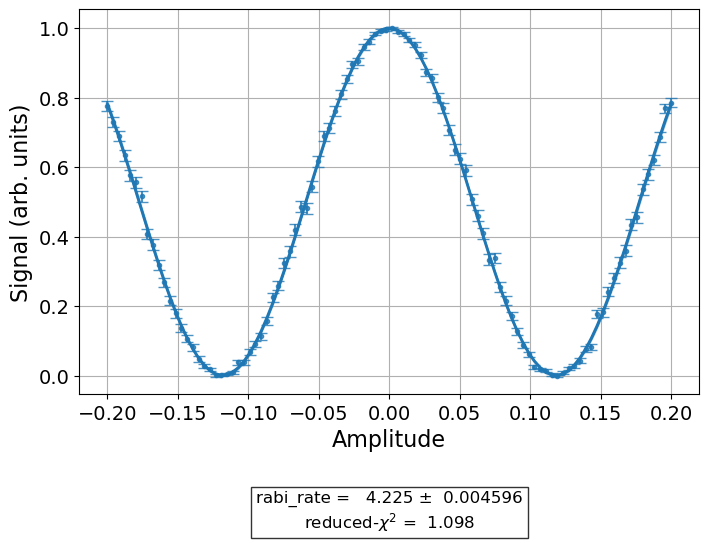

In [5]:
jax_results[0][0].figure(0)

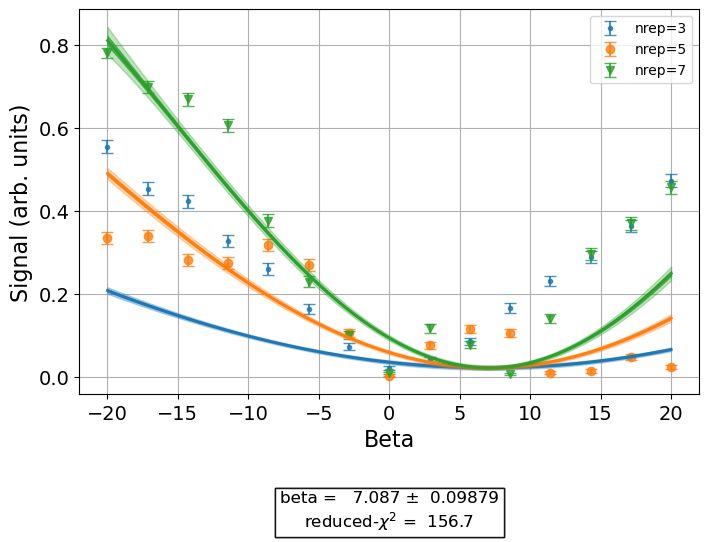

In [6]:
standard_results[0][1].figure(0)

In [7]:
jax_backend.target["x"][(0,)].calibration

ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=7.3185557673, amp=0.11835589, angle=0), DriveChannel(0)), name="x", transform=AlignLeft())

In [8]:
backend_estimator = BackendEstimator(backend=standard_backend)
backend_estimator_v2 = BackendEstimatorV2(backend=standard_backend)
aer_estimator = AerEstimator()
aer_estimator_v2 = AerEstimatorV2()
base_estimator = Estimator()
base_estimator_v2 = StatevectorEstimator()
pulse_estimator = PulseEstimatorV2(backend=standard_backend)
jax_estimator = DynamicsBackendEstimator(backend=jax_backend)

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_98937/3387774139.py:1: DeprecationWarning: The class ``qiskit.primitives.backend_estimator.BackendEstimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendEstimator` class is `BackendEstimatorV2`.
  backend_estimator = BackendEstimator(backend=standard_backend)
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_98937/3387774139.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  base_estimator = Estimator()


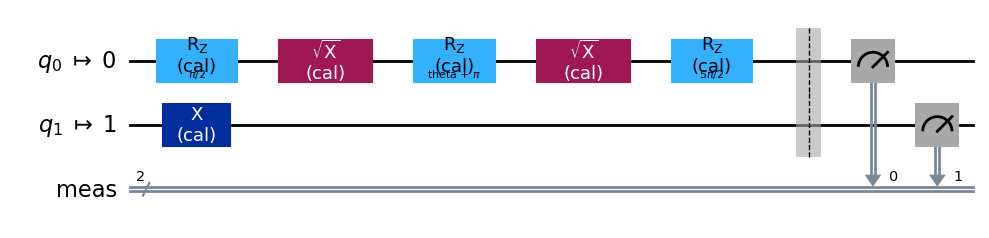

In [14]:
from qiskit import transpile

observable = SparsePauliOp.from_list([("ZZ", 1.0)])

param = Parameter("theta")
qc = QuantumCircuit(2)
qc.rx(param, 0)
qc.x(1)
qc.measure_all()
qc = transpile(qc, standard_backend, optimization_level=0)
qc.draw("mpl")

In [16]:
print("Expectation value for", observable.paulis)
param_val = np.pi / 3
pub = (
    qc.remove_final_measurements(inplace=False),
    observable,
    [param_val],
    1 / np.sqrt(5000),
)
print(
    "Qiskit v1",
    base_estimator.run(
        qc.remove_final_measurements(inplace=False),
        observable,
        parameter_values=param_val,
    )
    .result()
    .values,
)
print(
    "Qiskit v2",
    base_estimator_v2.run([pub]).result()[0].data.evs,
)
print(
    "Aer",
    aer_estimator.run(
        qc.remove_final_measurements(inplace=False),
        observable,
        parameter_values=param_val,
        shots=5000,
    )
    .result()
    .values,
)
print(
    "Aer v2",
    aer_estimator_v2.run(
        [pub],
    )
    .result()[0]
    .data.evs,
)
print(
    "BackendEstimator with DynamicsBackend",
    backend_estimator_v2.run(
        [pub],
    )
    .result()[0]
    .data.evs,
)

print(
    "PulseEstimator with DynamicsBackend",
    pulse_estimator.run(
        [pub],
    )
    .result()[0]
    .data.evs,
)


def get_schedule(qc, backend):
    def macro():
        return build_schedule(qc, backend)

    return macro


solver_2q_jax.circuit_macro = get_schedule(qc, jax_backend)
print(
    "Jax Backend",
    jax_estimator.run(
        qc.remove_final_measurements(inplace=False),
        observable,
        parameter_values=param_val,
    )
    .result()
    .values,
)

Expectation value for ['ZZ']
Qiskit v1 [-0.5]
Qiskit v2 -0.4704277190065807
Aer [-0.4872]
Aer v2 -0.48407442155028957
BackendEstimator with DynamicsBackend -0.4964
PulseEstimator with DynamicsBackend -0.5108203800361444
Time to run simulation:  0.7418920993804932
Jax Backend [-0.46679688]


In [14]:
jax_estimator.transpiled_circuits[0].draw("mpl")

In [18]:
op2 = Operator.from_label("I") ^ Operator.from_label("X")
op2

In [20]:
jax_estimator.preprocessed_circuits[0][1][0].draw("mpl")

In [21]:
solver_2q_jax.observables

In [24]:
solver_2q_jax.stored_results[1].evolve(solver_2q_jax.observables[1])

In [60]:
jax_estimator.backend